<a href="https://colab.research.google.com/github/ldcss/Chronic-kidney-disease/blob/main/CKD_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas necessárias
Inicialmente, iremos importar todas as bibliotecas que iremos utilizar ao longo desse notebook.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.base import TransformerMixin
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import boxcox
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve, validation_curve)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import warnings

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC



# Carregando a base de dados

A base de dados que utilizaremos é um arquivo de extensão .csv, e para realizarmos a manipulação e análise dos dados que estão contidos neste dataset, utilizaremos a biblioteca pandas.


In [ ]:
df = pd.read_csv('/content/kidney_disease.csv')


df.drop(["id"],axis=1,inplace=True) 

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

In [ ]:
df.head(7)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd
5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,74.0,...,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,100.0,...,36,NaN,NaN,no,no,no,good,no,no,ckd


In [ ]:
df.tail(7)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
393,43.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,117.0,...,54,7400,5.4,no,no,no,good,no,no,notckd
394,50.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,137.0,...,45,9500,4.6,no,no,no,good,no,no,notckd
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51,7200,5.9,no,no,no,good,no,no,notckd
399,58.0,80.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,131.0,...,53,6800,6.1,no,no,no,good,no,no,notckd


#Limpeza do banco de dados

Aqui observamos as colunas do tipo objeto, de modo que, ao decorrer do notebook, descartaremos as colunas do tipo categórico, utilizando apenas o numérico para o uso do classificador bayesiano.

Além disso, podemos encontrar os valores de cada campo, neste caso procurando há valores nulos ou mal formatados, para a limpeza do dataset.

In [ ]:
cat_col=[col for col in df.columns if df[col].dtype=='object']
for col in cat_col:
    print('{} has {} values '.format(col,df[col].unique()))
    print('\n')

rbc has [nan 'normal' 'abnormal'] values 


pc has ['normal' 'abnormal' nan] values 


pcc has ['notpresent' 'present' nan] values 


ba has ['notpresent' 'present' nan] values 


pcv has ['44' '38' '31' '32' '35' '39' '36' '33' '29' '28' nan '16' '24' '37' '30'
 '34' '40' '45' '27' '48' '\t?' '52' '14' '22' '18' '42' '17' '46' '23'
 '19' '25' '41' '26' '15' '21' '43' '20' '\t43' '47' '9' '49' '50' '53'
 '51' '54'] values 


wc has ['7800' '6000' '7500' '6700' '7300' nan '6900' '9600' '12100' '4500'
 '12200' '11000' '3800' '11400' '5300' '9200' '6200' '8300' '8400' '10300'
 '9800' '9100' '7900' '6400' '8600' '18900' '21600' '4300' '8500' '11300'
 '7200' '7700' '14600' '6300' '\t6200' '7100' '11800' '9400' '5500' '5800'
 '13200' '12500' '5600' '7000' '11900' '10400' '10700' '12700' '6800'
 '6500' '13600' '10200' '9000' '14900' '8200' '15200' '5000' '16300'
 '12400' '\t8400' '10500' '4200' '4700' '10900' '8100' '9500' '2200'
 '12800' '11200' '19100' '\t?' '12300' '16700' '2600' '26400' '

Como observado, há algumas colunas que não foram tipadas corretamente, cujo tipo deva ser algo numérico, ao invés de pertencer ao conjunto dos campos que são categóricos (e que posteriormente serão descartados).

In [ ]:
features=['rc','pcv','wc']
def convert_dtype(df,feature):
    df[feature] = pd.to_numeric(df[feature], errors='coerce')
    
for feature in features:
    convert_dtype(df,feature)
    
df.dtypes

age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv               float64
wc                float64
rc                float64
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

Como observado na célula que mostra os valores únicos, há também má formatação nos dados do dataset, onde é necessário realizar um map para formatá-lo corretamente. 

In [ ]:
df['classification']=df['classification'].map({'ckd':1,'notckd':0, 'ckd\t':1})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 17  rc              269 non-null    flo

Text(0.5, 1.0, 'target Class')

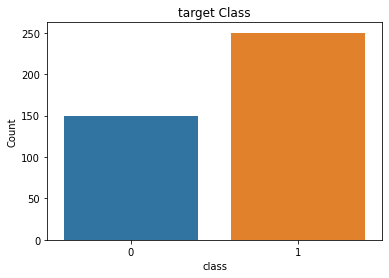

In [ ]:
# Distribuição numérica da quantidade das classes no dataset, onde 1 são os que possuem doença cronica renal e 0 os que não possuem
sns.countplot(x='classification',data=df)
plt.xlabel("class")
plt.ylabel("Count")
plt.title("target Class")

In [ ]:
# Aqui preenchemos os valores nulos com a média do valor numérico da coluna
num_cols=list(df.select_dtypes('float64'))
for col in num_cols:
    df[col]=df[col].fillna(df[col].median())
df.isnull().sum()

age                 0
bp                  0
sg                  0
al                  0
su                  0
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                 0
bu                  0
sc                  0
sod                 0
pot                 0
hemo                0
pcv                 0
wc                  0
rc                  0
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

#Exploração do banco de dados

Observação na distribuição das features na base de dados

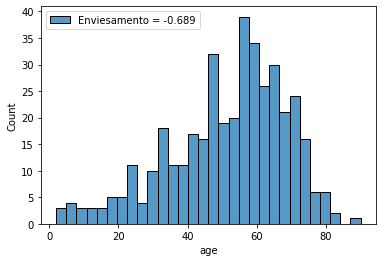

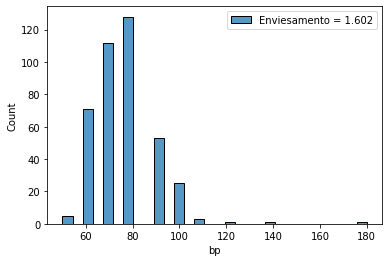

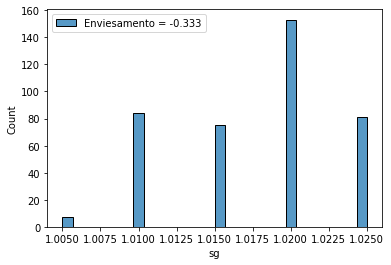

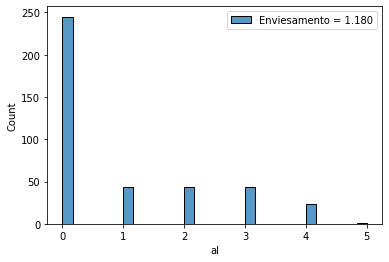

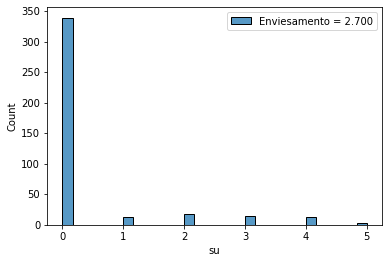

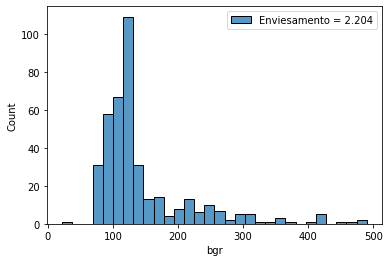

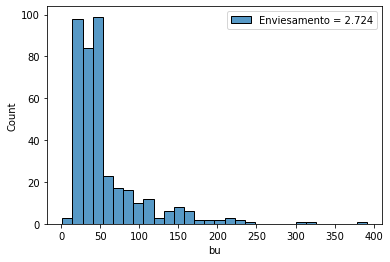

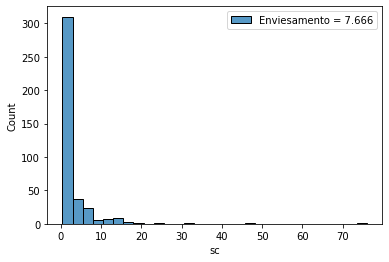

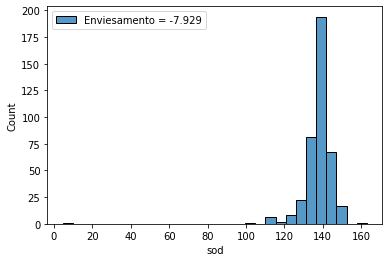

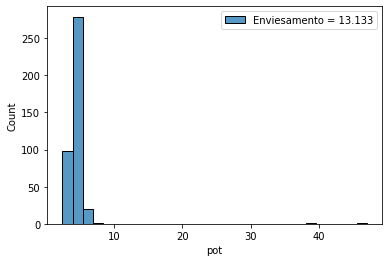

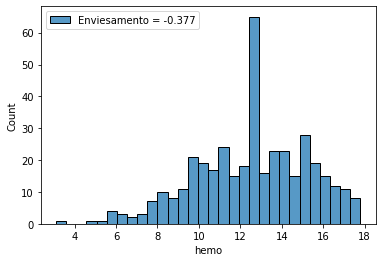

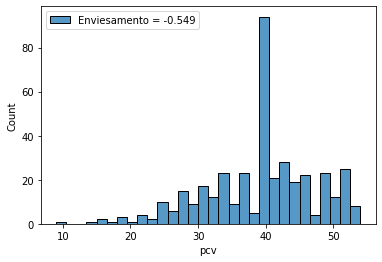

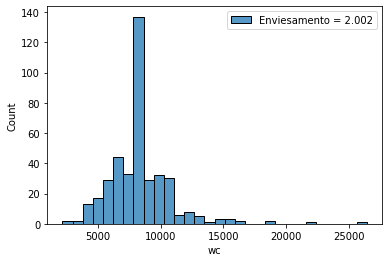

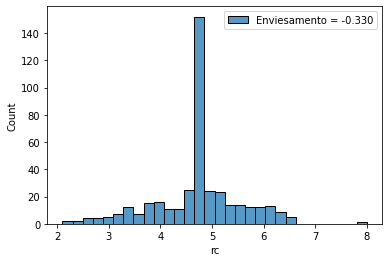

In [ ]:
cols=[col for col in df.columns if df[col].dtype=='float64']
for feat in cols:
  skew = df[feat].skew()
  sns.histplot(df[feat], kde= False, label='Enviesamento = %.3f' %(skew), bins=30)
  plt.legend(loc='best')
  plt.show()

Com a análise da distribuição, fica claro que nenhuma variável foi distribuída normalmente. Deste modo, é nitido o enviesamento de algumas features, onde possívelmente há a presença de muitos outliers, sendo necessária a sua detecção;.

In [ ]:
# Detecta observações com mais de um outlier

def outlier_hunt(df):
    outlier_indices = []
    
    # itera sobre as features (colunas)
    for col in df.columns.tolist():
        # primeiro quartil (25%)
        Q1 = np.percentile(df[col], 25)
        
        # terceiro quartil (75%)
        Q3 = np.percentile(df[col],75)
        
        # faixa interquartil
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR
        
        # Determina uma lista de índices de outliers para coluna de recurso
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # acrescenta os índices discrepantes encontrados para col à lista de índices discrepantes
        outlier_indices.extend(outlier_list_col)
        
    # selecionar observações contendo mais de 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 3 )
    
    return multiple_outliers   

print('A base de dados contém %d observações com mais de 3 outliers' %(len(outlier_hunt(df[cols]))))

A base de dados contém 29 observações com mais de 3 outliers


Existem cerca de 29 observações com múltiplos outliers. Isso pode prejudicar a eficiência do nosso algoritmo de aprendizagem, sendo necessário a remoção destes no decorrer do notebook.

Examinando o grafico de boxplot das features, vemos que a variável wc possui valores muitos discrepantes.

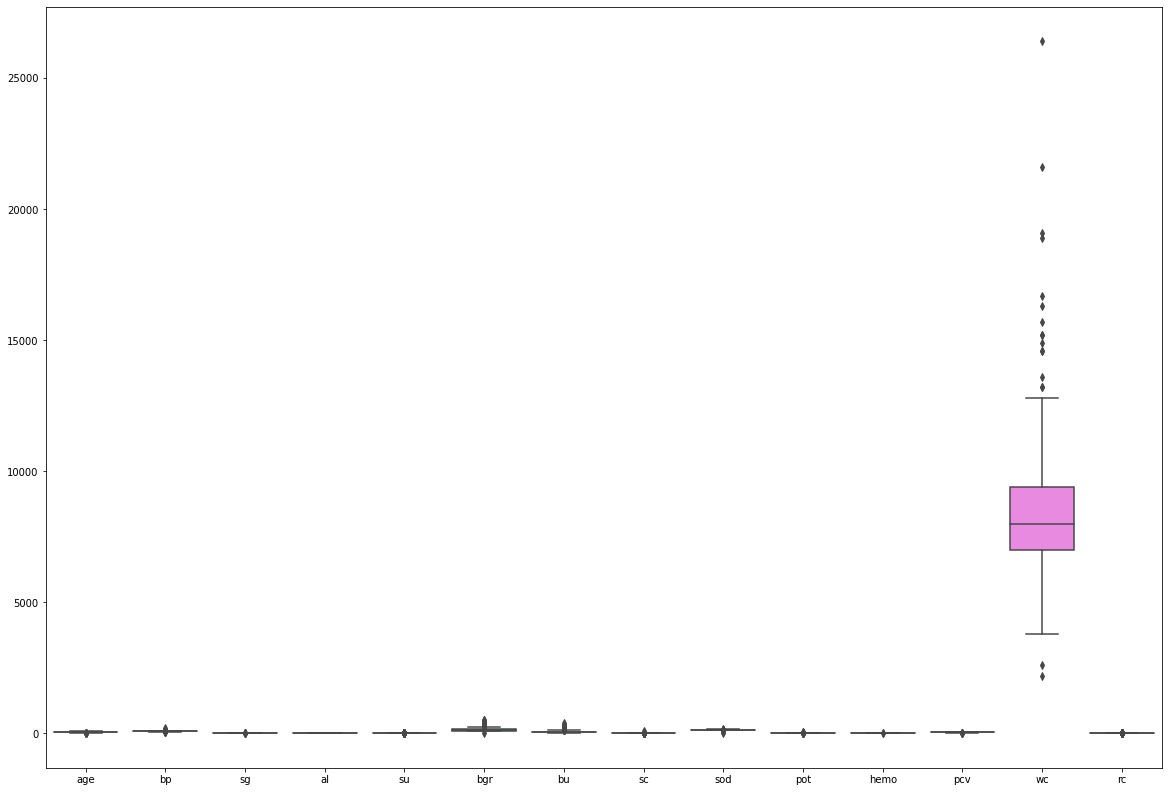

In [ ]:
plt.figure(figsize=(20,14))
sns.boxplot(data=df[cols])
plt.show()

In [ ]:
# Excluindo os registros que contém mais de 3 outliers, limpando a ainda mais a base de dados
outlier_indices = outlier_hunt(df[cols])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(371, 25)


Agora, com 29 registros a menos, temos um equilibrio maior entre o número total de cada classes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


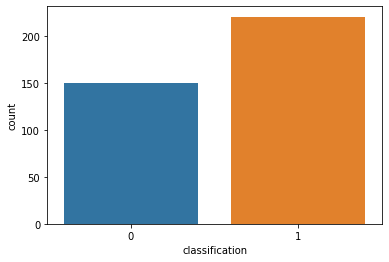

In [ ]:
sns.countplot(df['classification'])
plt.show()

In [ ]:
# Descartando todos os campos categóricos
cat_col=[col for col in df.columns if df[col].dtype=='object']
df.drop(cat_col,axis=1,inplace=True)
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             371 non-null    float64
 1   bp              371 non-null    float64
 2   sg              371 non-null    float64
 3   al              371 non-null    float64
 4   su              371 non-null    float64
 5   bgr             371 non-null    float64
 6   bu              371 non-null    float64
 7   sc              371 non-null    float64
 8   sod             371 non-null    float64
 9   pot             371 non-null    float64
 10  hemo            371 non-null    float64
 11  pcv             371 non-null    float64
 12  wc              371 non-null    float64
 13  rc              371 non-null    float64
 14  classification  371 non-null    int64  
dtypes: float64(14), int64(1)
memory usage: 43.6 KB


In [ ]:
# Checando se ainda há algum valor nulo
df.isnull().sum()

age               0
bp                0
sg                0
al                0
su                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
classification    0
dtype: int64

In [ ]:
cat_col=[col for col in df.columns]
for col in cat_col:
    print('{} has {} values '.format(col,df[col].unique()))
    print('\n')

age has [48.  7. 62. 51. 60. 68. 24. 52. 53. 50. 63. 40. 47. 61. 21. 42. 75. 69.
 55. 73. 70. 65. 76. 72. 82. 46. 45. 35. 54. 11. 59. 67. 15. 44. 26. 64.
 56.  5. 74. 38. 58. 71. 34. 17. 12. 43. 41. 57.  8. 39. 66. 81. 14. 27.
 83. 30.  4.  3.  6. 80. 90. 78. 19.  2. 33. 36. 37. 23. 49. 25. 20. 29.
 28. 32. 22. 79.] values 


bp has [ 80.  50.  70.  90. 100.  60. 110. 180. 120.] values 


sg has [1.02  1.01  1.005 1.015 1.025] values 


al has [1. 4. 2. 3. 0. 5.] values 


su has [0. 3. 4. 1. 2. 5.] values 


bgr has [121. 423. 117. 106.  74. 100. 410. 138.  70. 490. 380. 208.  98.  76.
  99. 114. 263. 173.  95. 108. 156. 264. 123.  93. 107. 159. 140. 171.
 270.  92. 137. 204.  79. 207. 124. 144.  91. 162. 246. 253. 141.  86.
 150. 146. 425. 112. 250. 360. 163. 129. 133. 102. 158. 165. 132. 104.
 127. 415. 169. 251. 109. 280. 210. 219.  94. 172. 298. 153.  88. 226.
 143. 115.  89. 233. 294. 323. 125.  90. 308. 118. 122. 214. 213. 268.
 256.  84. 105. 139.  78. 424. 303. 148. 160. 192. 

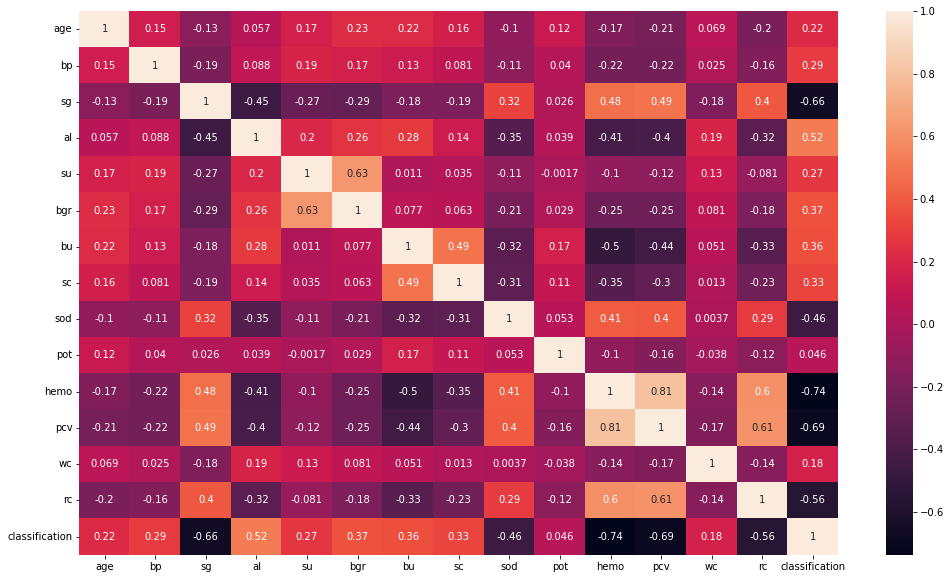

In [ ]:
# Mapa de correlação entre as features
plt.figure(figsize=(17,10))
corr_df = df.corr()
sns.heatmap(corr_df,annot=True)

Utilizando o mapa de correlação para analisar a correlação das variáveis restantes, vemos que hemo possui uma alta correlação com pcv, enquanto que ambas as variáveis possuem correlação notável com a feature rc. Logo, para diminuir o número de features restantes, escolhemos a abordagem de tirar ambas as variáveis que contém correlação com rc.

In [ ]:
df.drop(['hemo', 'pcv'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             371 non-null    float64
 1   bp              371 non-null    float64
 2   sg              371 non-null    float64
 3   al              371 non-null    float64
 4   su              371 non-null    float64
 5   bgr             371 non-null    float64
 6   bu              371 non-null    float64
 7   sc              371 non-null    float64
 8   sod             371 non-null    float64
 9   pot             371 non-null    float64
 10  wc              371 non-null    float64
 11  rc              371 non-null    float64
 12  classification  371 non-null    int64  
dtypes: float64(12), int64(1)
memory usage: 37.8 KB


Com a análise exploratória feita em nossa base de dados, saímos de 25 features e 400 registros para 11 features e 371 registros.

# Separando o conjunto de dados de validação

Em X, utilizamos iloc para guardar todos os campos exceto o último (a classe do dataset). Por outro lado, em Y utilizaremos iloc para pegar apenas o último campo, o da Classe. Separando assim as features e a classe do nosso dataset.

In [ ]:
# Separando as features da classe
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
# Utilizamos 30% do dataset para teste, enquanto que 70% será utilizada para o treino
X_train , X_test , y_train , y_test   = train_test_split(X,y,test_size = 0.3 , random_state=123)  

# Treinando o modelo

Nessa seção é feito o treinamento e medição de acurácia do classificador de Bayes, será utilizado o algoritmo classificador GaussianNB, já que todos elementos do nosso dataset se tratam de valores numéricos.


In [ ]:
knb = GaussianNB()
knb.fit(X_train,y_train)

GaussianNB()

In [ ]:
y_pred_knb = knb.predict(X_test) 

In [ ]:
# Importando métricas para avaliar o desempenho do modelo
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
score_knb = accuracy_score(y_pred_knb,y_test)
score_knb

0.8482142857142857

A acurácia do modelo se encontra em 84%.


In [ ]:
print("train score: " + str(knb.score(X_train, y_train)))
print("test score: " + str(knb.score(X_test, y_test)))

train score - 0.9111969111969112
test score - 0.8482142857142857


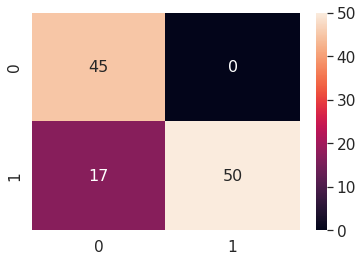

In [ ]:
# Fazendo a matriz de confusão
cm_knb = confusion_matrix(y_test,y_pred_knb)

sns.set(font_scale=1.4)
sns.heatmap(cm_knb, annot=True, annot_kws={"size": 16})

plt.show()

De acordo com a matriz de confusão, não houve casos de falso positivo. Por outro lado, houveram 17 casos em que houveram falsos negativos.

In [ ]:
print(classification_report(y_test, y_pred_knb))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84        45
           1       1.00      0.75      0.85        67

    accuracy                           0.85       112
   macro avg       0.86      0.87      0.85       112
weighted avg       0.89      0.85      0.85       112



# Comparando o classificador com outras abordagens

# Decision Tree

In [ ]:
dtc = DecisionTreeClassifier(criterion='entropy',random_state=0)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [ ]:
y_pred_dtc = dtc.predict(X_test) 

In [ ]:
score_dtc = accuracy_score(y_pred_dtc,y_test)
score_dtc

0.9732142857142857

A acurácia do modelo utilizando a abordagem de decision tree foi 97%, 13% a mais que a abordagem bayesiana.

In [ ]:
print("train score: " + str(dtc.score(X_train, y_train)))
print("test score: " + str(dtc.score(X_test, y_test)))

train score - 1.0
test score - 0.9732142857142857


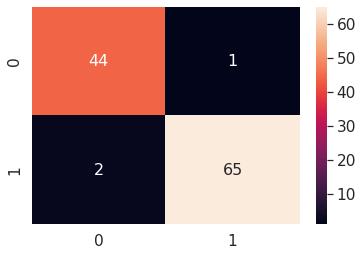

In [ ]:
# Fazendo a matriz de confusão
cm_dtc = confusion_matrix(y_test,y_pred_dtc)

sns.set(font_scale=1.4)
sns.heatmap(cm_dtc, annot=True, annot_kws={"size": 16})

plt.show()

De acordo com a matriz de confusão, houve apenas um caso de falso positivo. Por outro lado, em apenas dois casos houveram falsos negativos.

In [ ]:
print(classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       0.98      0.97      0.98        67

    accuracy                           0.97       112
   macro avg       0.97      0.97      0.97       112
weighted avg       0.97      0.97      0.97       112



# Support Vector Machine

In [ ]:
# Fitting SVM para a base de treinamento
svm = SVC(kernel='linear', random_state=0)
svm.fit(X_train,y_train)

SVC(kernel='linear', random_state=0)

In [ ]:
# Prevendo o resultado de teste
y_pred_svm = svm.predict(X_test)

In [ ]:
score_svm = accuracy_score(y_pred_svm,y_test)
score_svm

0.9553571428571429

A acurácia do modelo utilizando a abordagem de decision tree foi 95%, 11% a mais que a abordagem bayesiana.

In [ ]:
print("train score: " + str(svm.score(X_train, y_train)))
print("test score: " + str(svm.score(X_test, y_test)))

train score - 0.9806949806949807
test score - 0.9553571428571429


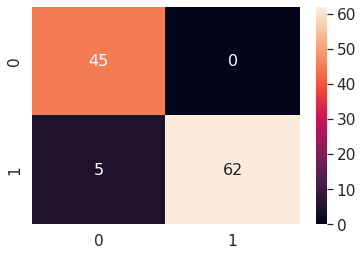

In [ ]:
# Fazendo a matriz de confusão
cm_svm = confusion_matrix(y_test,y_pred_svm)

sns.set(font_scale=1.4) 
sns.heatmap(cm_svm, annot=True, annot_kws={"size": 16}) 

plt.show()

De acordo com a matriz de confusão, não houve caso de falso positivo. Por outro lado, em cinco casos houveram falsos negativos.

In [ ]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        45
           1       1.00      0.93      0.96        67

    accuracy                           0.96       112
   macro avg       0.95      0.96      0.95       112
weighted avg       0.96      0.96      0.96       112



# Conclusão
Apesar de utilizar o mesmo dataset, o classificador bayesiano demonstra uma acurácia menor do que outras abordagens mais sólidas. Porém, apesar da comparação, o classificador apresentou 84% de acurácia em suas previsões, que acaba se tornando um ótimo resultado para a abordagem escolhida.